# Credit Card Fradulent Transaction Detection

### - Mrinalini Ineti Ramakanth

## Introduction
Detection of credit card fraud is of atmost importance for all the credit card companies. It is essential for these companies to detect any potential fraudulentt transaction so that customers are not charged for items they did not purchase. 

## Objective
Goal of this project is to explore various classifiers and to predict if a transaction is fraudulent or not. Evaluate the performance of these classifiers using various Precision-Recall curve, Cohen's Kappa and Matthews coefficient.

## Dataset
The dataset is the Kaggle Credit Card Fraud Detection dataset : https://www.kaggle.com/mlg-ulb/creditcardfraud. It contains two-day transactions made on 09/2013 by European cardholders. The dataset contains 492 frauds out of 284,807 transactions. Thus, it is highly unbalanced, with the positive (frauds) accounting for only 0.17%.

Due to confidentiality the original feature names or background information of the data is not reavelaed in the dataset provided. Features V1, V2, … V28 are the principal components obtained with PCA transformation. The only features which have not been transformed are ‘Time’ and ‘Amount’. ‘Time’ is the seconds elapsed between each transaction and the first. ‘Amount’ is the transaction amount. ‘Class’ is the response variable with 1 as fraud and 0 otherwise.

The dataset can be accessed from the link : https://drive.google.com/file/d/1OdR6plTfpgqi1j6WHlq0f__WamkIPbbh/view?usp=sharing

### Importing all the necessary libraries and packages. 

In [6]:
import csv
import math
import numpy as np
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

### Read the data 



In [7]:
df = pd.read_csv("./creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Preprocessing
Steps:
1. Remove duplicate records
2. Split the data into train and test sets
3. Apply SMOTE(Synthetic Minority Oversampling Technique) on training set.
    - The final goal of the model is to work with real life data distribution, therefore the test data and validation data has to stay unchanged.The resampling of the training data is to better represent the minority class so your classifier would have more samples to learn from (Oversampling). One logical explanation as to why SMOTE is applied to only training data while test data is unchangedis that in a real-world scenario, you wouldn't have access to the target variable (that's what you want to predict ) and in order to perform resampling, you need to know which class a sample belongs to for you find it's nearest neighbor(s) (oversampling).

In [8]:
# Remove duplicate records
df.drop_duplicates(keep=False,inplace=True) 
X = df.iloc[:,0:30]
y=df[["Class"]]

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.20, random_state=2)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_res,columns=['time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
y_train = pd.DataFrame(y_res,columns=["labels"])

### Plotting the Number of Fraud Transactions

In [9]:
normal_transactions = df[df.Class == 0].groupby(["Amount"]).size().reset_index()
normal_transactions.columns = ["Amount", "Counts"]

fraud_transactions = df[df.Class == 1].groupby(["Amount"]).size().reset_index()
fraud_transactions.columns = ["Amount", "Counts"]

Text(0.5, 1.0, 'Number of fradulent transactions')

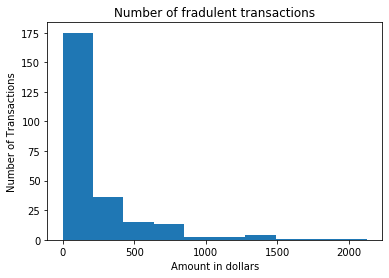

In [10]:
plt.hist(fraud_transactions["Amount"],bins=10)
plt.xlabel("Amount in dollars")
plt.ylabel("Number of Transactions")
plt.title("Number of fradulent transactions")

### Classifiers Used:
1. Logistic Regression
2. Linear Discriminant Analysis
3. Quadratic Discriminant Analysis
4. k Nearest Neighbours (kNN)
5. Naive Bayes Classifier
6. Decision Trees
7. Random Forests

### Logistic Regression

In [11]:
model_LR = LogisticRegression()
model_LR.fit(X_train,y_train)
y_pred_LR = model_LR.predict(X_test)
CM_LR = confusion_matrix(y_test,y_pred_LR)
precision_LR = precision_score(y_test,y_pred_LR)
recall_LR = recall_score(y_test,y_pred_LR)
F1_LR = f1_score(y_test,y_pred_LR)

print("Confusion Matrix")
print(CM_LR)
print(" ")

TN = CM_LR[0][0]
FP = CM_LR[0][1]
FN = CM_LR[1][0]
TP = CM_LR[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")

print("Precision = ",precision_LR)
print("Recall = ",recall_LR)
print("F1 Score = ",F1_LR)


mcc_LR = matthews_corrcoef(y_test, y_pred_LR)
cohen_score_LR = cohen_kappa_score(y_test, y_pred_LR)

Confusion Matrix
[[55492   995]
 [    7    97]]
 
True Positives =  97
False Positives =  995
True Negatives =  55492
False Negatives =  7
 
Precision =  0.08882783882783883
Recall =  0.9326923076923077
F1 Score =  0.1622073578595318


### Plotting the feature importance according to Logistic Regression

Coefficients of features in the model
     index  Coefficients
14     V14      1.033036
3       V3      0.715227
4       V4      0.638389
17     V17      0.494170
12     V12      0.483031
10     V10      0.374819
16     V16      0.327904
13     V13      0.322573
9       V9      0.286080
22     V22      0.283303
8       V8      0.238746
6       V6      0.228269
15     V15      0.224254
11     V11      0.178622
25     V25      0.139076
5       V5      0.130535
21     V21      0.123073
7       V7      0.104899
19     V19      0.087238
1       V1      0.086170
27     V27      0.063537
28     V28      0.060972
26     V26      0.039649
24     V24      0.039003
2       V2      0.028154
23     V23      0.026942
18     V18      0.026009
20     V20      0.019567
29  Amount      0.000281
0     time      0.000031


Text(0.5, 1.0, 'Important features according to Logistic Regression')

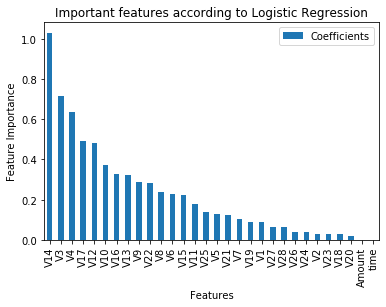

In [12]:
cdf = pd.DataFrame(abs(model_LR.coef_.T), X_train.columns.T, columns=['Coefficients']).reset_index()
print("Coefficients of features in the model")
cdf.sort_values('Coefficients',inplace=True,ascending=False)
print(cdf)
cdf.plot(x="index",y="Coefficients",kind='bar')
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Important features according to Logistic Regression")

Time and Amount are the least important features according to the above graph

### Linear Discriminant Analysis

In [13]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(X_train,y_train)
y_pred_LDA = model_LDA.predict(X_test)
precision_LDA = precision_score(y_test,y_pred_LDA)
recall_LDA = recall_score(y_test,y_pred_LDA)
F1_LDA = f1_score(y_test,y_pred_LDA)

CM_LDA = confusion_matrix(y_test, y_pred_LDA)
print("Confusion Matrix")
print(CM_LDA)
print(" ")

TN = CM_LDA[0][0]
FP = CM_LDA[0][1]
FN = CM_LDA[1][0]
TP = CM_LDA[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")

print("Precision = ",precision_LDA)
print("Recall = ",recall_LDA)
print("F1 Score = ",F1_LDA)

mcc_LDA = matthews_corrcoef(y_test, y_pred_LDA)
cohen_score_LDA = cohen_kappa_score(y_test, y_pred_LDA)

Confusion Matrix
[[55664   823]
 [   12    92]]
 
True Positives =  92
False Positives =  823
True Negatives =  55664
False Negatives =  12
 
Precision =  0.1005464480874317
Recall =  0.8846153846153846
F1 Score =  0.18056918547595682


### Quadratic Discriminant Analysis

In [14]:
model_QDA = QuadraticDiscriminantAnalysis()
model_QDA.fit(X_train,y_train)
y_pred_QDA = model_QDA.predict(X_test)
precision_QDA = precision_score(y_test,y_pred_QDA)
recall_QDA = recall_score(y_test,y_pred_QDA)
F1_QDA = f1_score(y_test,y_pred_QDA)

CM_QDA = confusion_matrix(y_test, y_pred_QDA)
print("Confusion Matrix")
print(CM_QDA)
print(" ")

TN = CM_QDA[0][0]
FP = CM_QDA[0][1]
FN = CM_QDA[1][0]
TP = CM_QDA[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")

print("Precision = ",precision_QDA)
print("Recall = ",recall_QDA)
print("F1 Score = ",F1_QDA)


mcc_QDA = matthews_corrcoef(y_test, y_pred_QDA)
cohen_score_QDA = cohen_kappa_score(y_test, y_pred_QDA)

Confusion Matrix
[[54880  1607]
 [   10    94]]
 
True Positives =  94
False Positives =  1607
True Negatives =  54880
False Negatives =  10
 
Precision =  0.05526161081716637
Recall =  0.9038461538461539
F1 Score =  0.1041551246537396


### k Nearest Neighbours (kNN)

In [15]:
model_kNN = model_kNN = KNeighborsClassifier(n_neighbors= 3)
model_kNN.fit(X_train,y_train)
y_pred_kNN = model_kNN.predict(X_test)
precision_kNN = precision_score(y_test,y_pred_kNN)
recall_kNN = recall_score(y_test,y_pred_kNN)
F1_kNN = f1_score(y_test,y_pred_kNN)

CM_kNN = confusion_matrix(y_test,y_pred_kNN)
print("Confusion Matrix")
print(CM_kNN)
print(" ")

TN = CM_kNN[0][0]
FP = CM_kNN[0][1]
FN = CM_kNN[1][0]
TP = CM_kNN[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")


print("Precision = ",precision_kNN)
print("Recall = ",recall_kNN)
print("F1 Score = ",F1_kNN)

mcc_kNN = matthews_corrcoef(y_test, y_pred_kNN)
cohen_score_kNN = cohen_kappa_score(y_test, y_pred_kNN)

Confusion Matrix
[[53747  2740]
 [   46    58]]
 
True Positives =  58
False Positives =  2740
True Negatives =  53747
False Negatives =  46
 
Precision =  0.020729092208720514
Recall =  0.5576923076923077
F1 Score =  0.03997243280496209


### Naive Bayes Classifier

In [16]:

model_NB = GaussianNB()
model_NB.fit(X_train,y_train)
y_pred_NB = model_NB.predict(X_test)
precision_NB = precision_score(y_test,y_pred_NB)
recall_NB = recall_score(y_test,y_pred_NB)
F1_NB = f1_score(y_test,y_pred_NB)

CM_NB = confusion_matrix(y_test,y_pred_NB)
print("Confusion Matrix")
print(CM_NB)
print(" ")

TN = CM_NB[0][0]
FP = CM_NB[0][1]
FN = CM_NB[1][0]
TP = CM_NB[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")

print("Precision = ",precision_NB)
print("Recall = ",recall_NB)
print("F1 Score = ",F1_NB)

mcc_nb = matthews_corrcoef(y_test, y_pred_NB)
cohen_score_nb = cohen_kappa_score(y_test, y_pred_NB)

Confusion Matrix
[[56089   398]
 [   19    85]]
 
True Positives =  85
False Positives =  398
True Negatives =  56089
False Negatives =  19
 
Precision =  0.17598343685300208
Recall =  0.8173076923076923
F1 Score =  0.28960817717206133


### Decision Trees

In [17]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
y_pred_dt = model_dt.predict(X_test)
precision_dt = precision_score(y_test,y_pred_dt)
recall_dt = recall_score(y_test,y_pred_dt)
F1_dt = f1_score(y_test,y_pred_dt)

CM_dt = confusion_matrix(y_test,y_pred_dt)
print("Confusion Matrix")
print(CM_dt)
print(" ")

TN = CM_dt[0][0]
FP = CM_dt[0][1]
FN = CM_dt[1][0]
TP = CM_dt[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")

print("Precision = ",precision_dt)
print("Recall = ",recall_dt)
print("F1 Score = ",F1_dt)

mcc_dt = matthews_corrcoef(y_test, y_pred_dt)
cohen_score_dt = cohen_kappa_score(y_test, y_pred_dt)

Confusion Matrix
[[56383   104]
 [   22    82]]
 
True Positives =  82
False Positives =  104
True Negatives =  56383
False Negatives =  22
 
Precision =  0.44086021505376344
Recall =  0.7884615384615384
F1 Score =  0.5655172413793104


### Random Forests

In [18]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)  
y_pred_RF = model_RF.predict(X_test)
precision_RF = precision_score(y_test,y_pred_RF)
recall_RF = recall_score(y_test,y_pred_RF)
F1_RF = f1_score(y_test,y_pred_RF)

CM_RF = confusion_matrix(y_test,y_pred_RF)
print("Confusion Matrix")
print(CM_RF)
print(" ")

TN = CM_RF[0][0]
FP = CM_RF[0][1]
FN = CM_RF[1][0]
TP = CM_RF[1][1]

print("True Positives = ",TP)
print("False Positives = ",FP)
print("True Negatives = ",TN)
print("False Negatives = ",FN)
print(" ")

print("Precision = ",precision_RF)
print("Recall = ",recall_RF)
print("F1 Score = ",F1_RF)


mcc_RF = matthews_corrcoef(y_test, y_pred_RF)
cohen_score_RF = cohen_kappa_score(y_test, y_pred_RF)

Confusion Matrix
[[56478     9]
 [   15    89]]
 
True Positives =  89
False Positives =  9
True Negatives =  56478
False Negatives =  15
 
Precision =  0.9081632653061225
Recall =  0.8557692307692307
F1 Score =  0.8811881188118811


### Plotting feature importance according to Random Forest Classifier

Text(0.5, 1.0, 'Important features according to Random Forest Classifier')

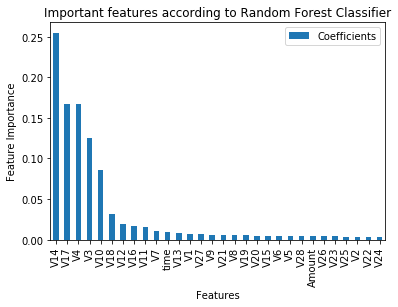

In [19]:
fi = pd.DataFrame(abs(model_RF.feature_importances_.T), X_train.columns.T, columns=['Coefficients']).reset_index()
fi.sort_values('Coefficients',inplace=True,ascending=False)
fi.plot(x="index",y="Coefficients",kind='bar')
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Important features according to Random Forest Classifier")

Random Forest classifier further optimizes the number of features selected compared to Logistic Regression  

#### Matthews Correlation Coefficient
The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications.It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient between the observed and predicted binary classifications; it returns a value between −1 and +1. A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. Its a metric used for imbalanced data.

In [20]:
print("Logistic Regression :",mcc_LR)
print("Linear Discriminant Analysis :",mcc_LDA)
print("Quadratic Discriminant Analysis :",mcc_QDA)
print("k Nearest Neighbours :",mcc_kNN)
print("Random Forests Classifier :",mcc_RF)
print("Decision Trees :",mcc_dt)
print("Naive Bayes Classifier :",mcc_nb)

Logistic Regression : 0.28490165219887476
Linear Discriminant Analysis : 0.29545300393781077
Quadratic Discriminant Analysis : 0.21958227032155878
k Nearest Neighbours : 0.10059589894404455
Random Forests Classifier : 0.8813661561906059
Decision Trees : 0.5886279225386698
Naive Bayes Classifier : 0.3772509500655822


From the above metrics Random forest classifier performs the best.                                                             
LDA performs better than QDA which indicates the data is linearly seperable


### ROC curves
ROC curves are not very useful for evaluating imbalanced classes

AUC for  Logistic Regression  =  0.957538817644904
AUC for  LDA  =  0.9350228303040454
AUC for  QDA  =  0.9376985650884955
AUC for  kNN  =  0.7545927858145713
AUC for  Naive Bayes Classifier  =  0.9051309116733461
AUC for  Decision Trees  =  0.8933102034368697
AUC for  Random Forests  =  0.9278049510370665


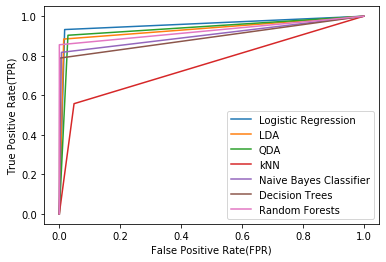

In [21]:
classifier_predictions = [y_pred_LR,y_pred_LDA,y_pred_QDA,y_pred_kNN,y_pred_NB,y_pred_dt,y_pred_RF]
classifier_names = ["Logistic Regression","LDA","QDA","kNN","Naive Bayes Classifier","Decision Trees","Random Forests"]
for i in range(len(classifier_predictions)):
    fpr,tpr,thresholds = roc_curve(y_test,classifier_predictions[i])
    plt.plot(fpr,tpr,label= classifier_names[i])
    plt.xlabel("False Positive Rate(FPR)")
    plt.ylabel("True Positive Rate(TPR)")
    plt.legend()
    print("AUC for ",classifier_names[i]," = ",auc(fpr,tpr))

### Cohen's kappa coefficient
Cohen's kappa statistic is a very good measure that can handle very well both multi-class and imbalanced class problems. Cohen's kappa is always less than or equal to 1. Values of 0 or less, indicate that the classifier is useless.

In [22]:
print("Logistic Regression :",cohen_score_LR)
print("Linear Discriminant Analysis :",cohen_score_LDA)
print("Quadratic Discriminant Analysis :",cohen_score_QDA)
print("k Nearest Neighbours :",cohen_score_kNN)
print("Random Forests Classifier :",cohen_score_RF)
print("Decision Trees :",cohen_score_dt)
print("Naive Bayes Classifier :",cohen_score_nb)


Logistic Regression : 0.15938635282118474
Linear Discriminant Analysis : 0.17785580389863875
Quadratic Discriminant Analysis : 0.10104138158019926
k Nearest Neighbours : 0.0365582108667869
Random Forests Classifier : 0.8809758795856418
Decision Trees : 0.5644905770593027
Naive Bayes Classifier : 0.28745322132045237


### Precision-Recall curve
Precision-Recall curve is a useful metric to measure the performance of models dealing with imbalanced data. From the below precision-recall curve Random forest classifier performs the best.

AUC for  Logistic Regression  =  0.5089841724984681
AUC for  LDA  =  0.49084919222566376
AUC for  QDA  =  0.47780448755157134
AUC for  kNN  =  0.2877793769486234
AUC for  Naive Bayes Classifier  =  0.49497568774480794
AUC for  Decision Trees  =  0.6130175059036281
AUC for  Random Forests  =  0.8802610298934487


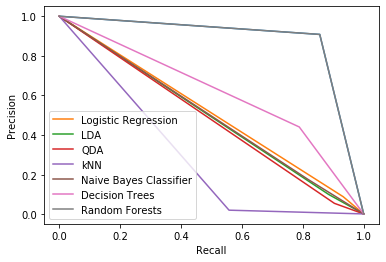

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_RF)
plt.plot(recall,precision)
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

classifier_predictions = [y_pred_LR,y_pred_LDA,y_pred_QDA,y_pred_kNN,y_pred_NB,y_pred_dt,y_pred_RF]
classifier_names = ["Logistic Regression","LDA","QDA","kNN","Naive Bayes Classifier","Decision Trees","Random Forests"]
for i in range(len(classifier_predictions)):
    precision, recall, thresholds = precision_recall_curve(y_test,classifier_predictions[i])
    plt.plot(recall,precision,label= classifier_names[i])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    print("AUC for ",classifier_names[i]," = ",auc(precision,recall))